In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
config.update('jax_enable_x64', True)

### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: good guesses for planets' mean periods

In [3]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

### define timestep dt, start/end times of integration

In [4]:
dt = 0.5 * 2
t_start, t_end = 155., 1495 + 1455
jttv = jaxttv(t_start, t_end, dt) # jaxttv class

### set observed transit times and errors (necessary to obtain model transit times)

In [5]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)


### least-squares fit for initializing HMC
- defaults to LM optimization with scipy.optimize.curve_fit
- if a good guess is not found, turning on amoeba may help

initial objective function: 5448.24 (53 data)

running LM optimization...
objective function: 46.17 (53 data)
# elapsed time (least square): 2.9 sec


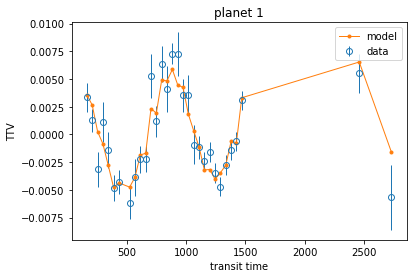

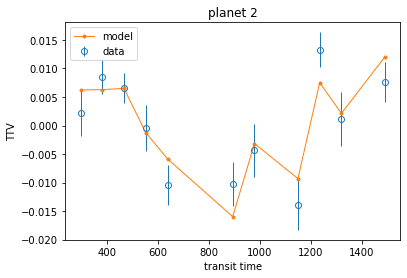

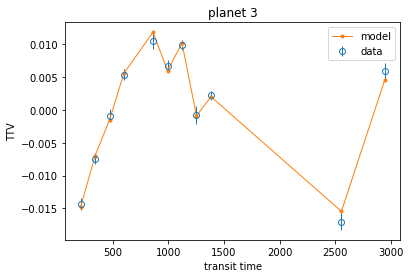

In [6]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1)

In [10]:
tc, de = jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))
print (de)

-4.972765113353539e-06


In [11]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

4.96 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  2.362789   45.153421 -0.017523 -0.044453  -0.0   -0.0  159.110433   
1  4.080329   85.313628  0.004990 -0.018216  -0.0   -0.0  295.319667   
2  5.220634  130.184146  0.000418 -0.014557  -0.0    0.0  212.023570   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.047782 -1.946280 -11.855893  0.000007 -0.366722 -0.930331  
1  0.018887 -1.303425 -11.309558  0.000012  0.264198 -0.964469  
2  0.014563 -1.542073 -11.063117  0.000016  0.028719 -0.999588  


### initialize HMC
- pdic_init: dict containing best-fit values
- tic_guess: used to set priors for times of inferior conjunction
- p_guess: used to set priors for osculating periods

In [14]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(p_init)
ones = jnp.ones_like(p_guess)
pdic_init

{'period': DeviceArray([ 45.15342068,  85.31362777, 130.18414599], dtype=float64),
 'cosi': DeviceArray([-0., -0., -0.], dtype=float64),
 'lnode': DeviceArray([-0., -0.,  0.], dtype=float64),
 'tic': DeviceArray([159.11043286, 295.31966714, 212.02357023], dtype=float64),
 'ecc': DeviceArray([0.04778151, 0.01888699, 0.01456318], dtype=float64),
 'lnmass': DeviceArray([-11.85589308, -11.30955833, -11.06311706], dtype=float64),
 'mass': DeviceArray([7.09661193e-06, 1.22552232e-05, 1.56801174e-05], dtype=float64),
 'cosw': DeviceArray([-0.36672218,  0.26419755,  0.02871938], dtype=float64),
 'sinw': DeviceArray([-0.9303305 , -0.96446859, -0.99958751], dtype=float64)}

In [15]:
from numpyro.infer import init_to_value
import numpyro
import numpyro.distributions as dist
import jax.random as random
def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    #cosO = numpyro.sample("cosO", dist.Normal(scale=jnp.array([1, 1])))
    #sinO = numpyro.sample("sinO", dist.Normal(scale=jnp.array([1, 1])))
    #lnode = jnp.arctan2(sinO, cosO)
    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.exp(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    #tcmodel, ediff = jttv.get_ttvs_hermite4(elements, jnp.hstack([1, mass]))
    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    #tcmodel = jnp.nan_to_num(tcmodel, nan=-jnp.inf)
    #ediff = jnp.nan_to_num(ediff, nan=jnp.inf)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=jttv.errorobs_flatten), obs=jttv.tcobs_flatten)

In [16]:
init_strategy = init_to_value(values=pdic_init)
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [17]:
nw, ns = 100, 100  # dt=1, all data, 1.5hr
nw, ns = 500, 1500 

In [18]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [19]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, mmin=0, mmax=1e-4, uniform_mass=True) # uniform prior for mass ratios

sample: 100%|███████████████████████████████████████████| 2000/2000 [19:10:20<00:00, 34.51s/it, 1023 steps of size 2.27e-03. acc. prob=0.90]


In [20]:
base = "kep51/linmass_dt%.1f_nw%d_ns%d_"%(dt, nw, ns)

In [21]:
base

'kep51/linmass_dt1.0_nw500_ns1500_'

In [22]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]     -0.50      0.44     -0.39     -1.15     -0.01    126.88      1.01
   cosw[1]      0.33      0.75      0.31     -1.01      1.50    332.31      1.00
   cosw[2]     -0.21      0.78     -0.19     -1.69      0.98    186.46      1.00
    ecc[0]      0.07      0.08      0.04      0.01      0.16    148.12      1.00
    ecc[1]      0.01      0.01      0.01      0.00      0.03    261.73      1.00
    ecc[2]      0.01      0.01      0.01      0.00      0.03    285.86      1.00
   mass[0]      0.00      0.00      0.00      0.00      0.00    313.77      1.01
   mass[1]      0.00      0.00      0.00      0.00      0.00    341.58      1.01
   mass[2]      0.00      0.00      0.00      0.00      0.00    397.68      1.00
 period[0]     45.15      0.00     45.15     45.15     45.15    480.57      1.00
 period[1]     85.31      0.00     85.31     85.31     85.32    337.50      1.00
 period[2]    130.18      0

In [23]:
import dill
with open(base+"mcmc.pkl", "wb") as f:
    dill.dump(mcmc, f)

In [24]:
samples = mcmc.get_samples()

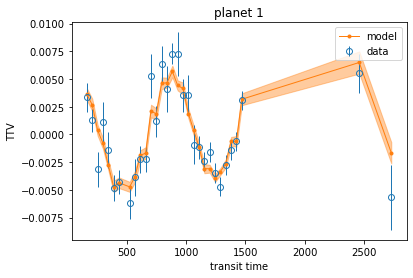

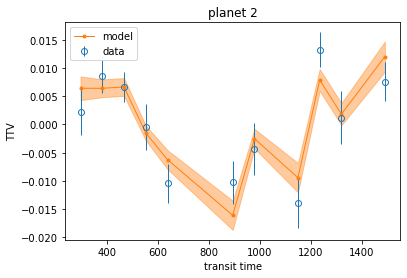

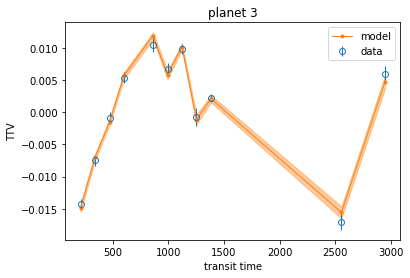

In [25]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=base+"postm")

In [26]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']
#keys = ['lnmass', 'tic', 'period', 'ecc', 'omega']

(array([  1.,   2.,   2.,  10.,  12.,  40.,  69., 291., 806., 267.]),
 array([-7.38357685, -7.13816005, -6.89274325, -6.64732646, -6.40190966,
        -6.15649286, -5.91107606, -5.66565927, -5.42024247, -5.17482567,
        -4.92940887]),
 <BarContainer object of 10 artists>)

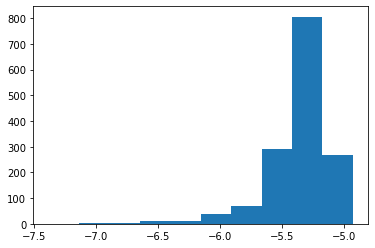

In [27]:
plt.hist(np.log10(np.abs(samples['ediff'])))

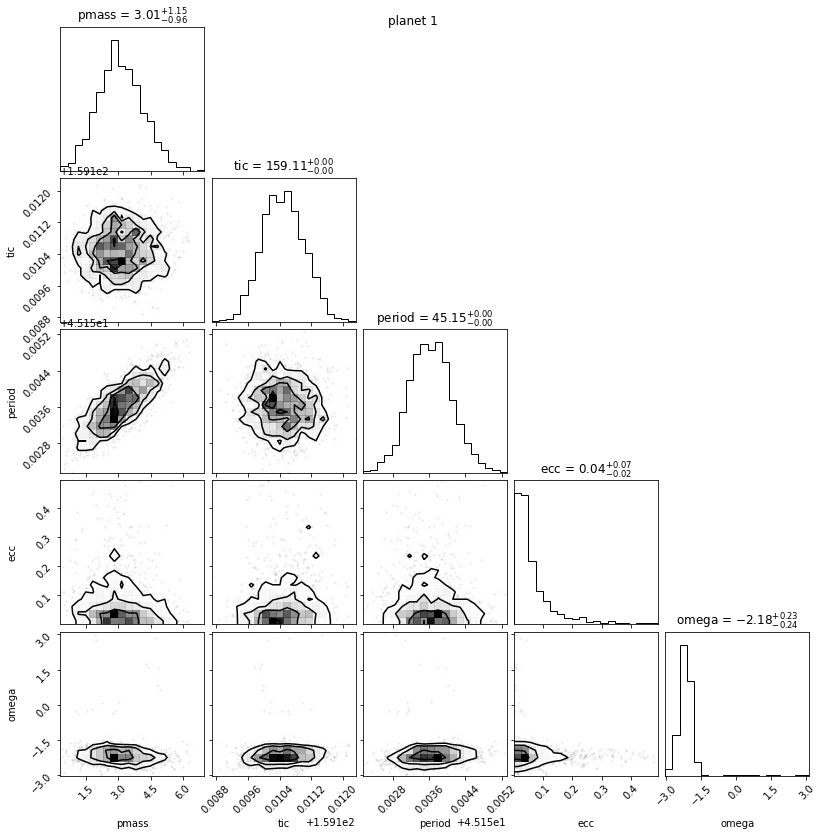

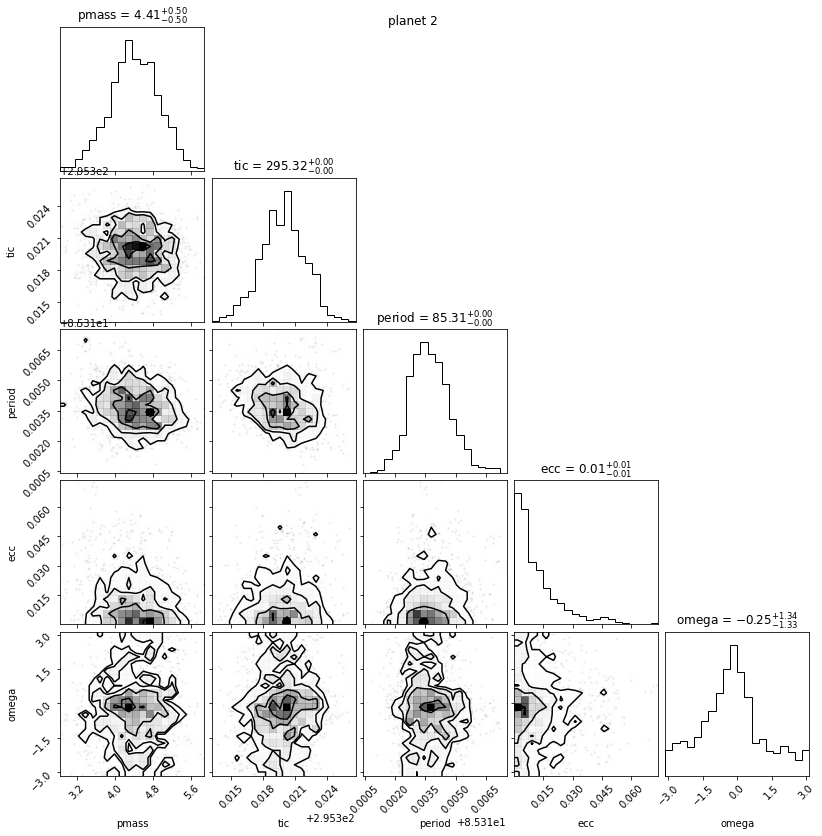

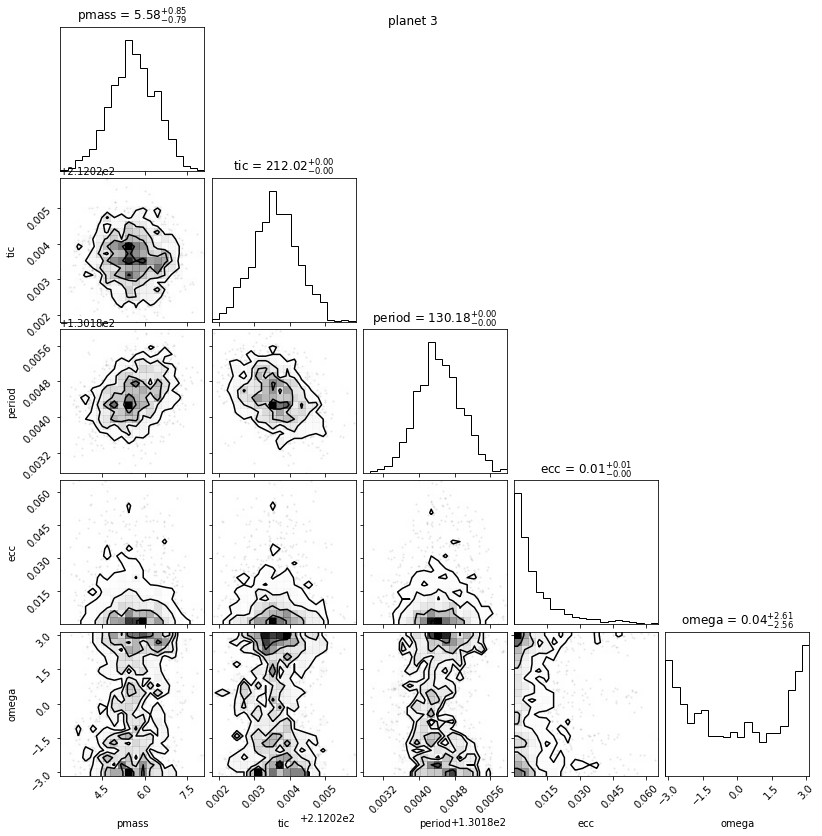

In [39]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles="%.2f")
    fig.suptitle("planet %d"%(j+1))
    plt.savefig(base+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight")

### check convergence

In [29]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           0.1000 (1/451 of innermost period)


In [34]:
k = 100

In [35]:
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))

(array([ 2.,  0.,  2., 11., 27.,  2.,  3.,  2.,  1.,  3.]),
 array([-0.2848537 , -0.22361972, -0.16238574, -0.10115176, -0.03991778,
         0.0213162 ,  0.08255019,  0.14378417,  0.20501815,  0.26625213,
         0.32748611]),
 <BarContainer object of 10 artists>)

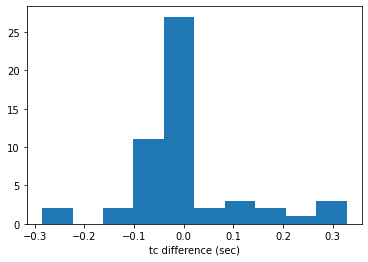

In [36]:
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)